In [1]:
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests  # library to handle requests
import json  # library to handle JSON files
import matplotlib.colors as colors
import matplotlib.cm as cm
from sklearn.cluster import KMeans
import folium  # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import numpy as np
import pandas as pd
import numpy
from bs4 import BeautifulSoup
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import NearestNeighbors

#Get the list of Toronto Neighbourhood
The list is obtained from wikiepdia and extracted using BeautifulSoup

links: 
- https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
- https://cocl.us/Geospatial_data

Webscraping Toronto Neighbourhood Data from Wikipedia

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data  = requests.get(url).text

In [3]:
soup = BeautifulSoup(data,"html5lib")

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.rename(columns={'PostalCode': 'Postal Code'}, inplace=True)
df

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Toronto Coordinates Data

In [5]:
# Function to get coords of a Toronto
lat_lng_coords = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Adding coords to main dataframe

df_toronto = pd.merge(df,lat_lng_coords,on='Postal Code')
df_toronto

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [7]:
print(df_toronto.dtypes)

Postal Code      object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object


# Get venues from Foursquare API

In [8]:
# Foursquare connection

CLIENT_ID = "DOUQMGKGXNQPBPWW4POSVY5Y2RHXPOQ0EXOI2D2ICDDZGOHT" # your Foursquare ID
CLIENT_SECRET = "QNGGGHGZFMQNCZBKU02FIEYQSIYYA3LE15ORPKKM3S1AWMX4" # your Foursquare Secret

In [9]:
category = "13032"
API_KEY = "fsq3d0rNVC3YVv91EYsmovrmY4BS7oaNdg+xhiva1rjlBoY="
radius = 10000
limit = 50 # max 50
VERSION = 20220301 # fecha en YYYYMMDD

lat = "43.660555"
lon = "-79.390740"

url = f"https://api.foursquare.com/v3/places/search?ll={lat},{lon}&radius={radius}&categories={category}&limit={limit}"

#url = "https://api.foursquare.com/v3/places/search?ll=1.323681%2C103.947566&radius=500&categories=13035&limit=10"

headers = {
    "Accept": "application/json",
    "Authorization": API_KEY
}

response = requests.request("GET", url, headers=headers)

print(response.text)

{"results":[{"fsq_id":"5a81ae339deb7d369fa7f146","categories":[{"id":13035,"name":"Coffee Shop","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_","suffix":".png"}}],"chains":[],"distance":598,"geocodes":{"main":{"latitude":43.658868,"longitude":-79.383807},"roof":{"latitude":43.658868,"longitude":-79.383807}},"link":"/v3/places/5a81ae339deb7d369fa7f146","location":{"address":"44 Gerrard St W","country":"CA","cross_street":"Yonge St","formatted_address":"44 Gerrard St W (Yonge St), Toronto ON M5G 2K2","locality":"Toronto","neighborhood":["Downtown Toronto"],"postcode":"M5G 2K2","region":"ON"},"name":"Hailed Coffee","related_places":{},"timezone":"America/Toronto"},{"fsq_id":"59ecf741da2e006b9e11a3d3","categories":[{"id":13033,"name":"Bubble Tea Shop","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/bubble_","suffix":".png"}},{"id":13065,"name":"Restaurant","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/default_","suffix":".png"}}],"ch

In [10]:
# changing the format of the result of the request to Json format
r = response.json()

In [11]:
print(type(r))

<class 'dict'>


Creation of a list of cafeteria names (name = Venue)

In [12]:
# save the names of the cafeteria names in a list
i = 0

venue_names = []
for venue in r["results"]:

# extract fields from the JSON
  venue_name = r["results"][i]["name"]

  venue_names.append(venue_name)

  # new iteration (counter)
  i +=1


In [13]:
print(type(venue_names))
print(venue_names)

<class 'list'>
['Hailed Coffee', 'The Alley', 'HotBlack Coffee', 'Fahrenheit Coffee', 'Dineen Coffee Co', 'Cafe Landwer', 'Snakes & Lattes College', 'Neo Coffee Bar', 'Rooster Coffee House', 'Tandem Coffee', 'Arvo Coffee', 'Contra Cafe', 'The Black Canary Espresso Bar', 'Le Beau', 'Boxcar Social', "Balzac's Coffee Roastery", 'White Squirrel Coffee Shop', 'Impact Kitchen', 'Hale Coffee', 'Aroma Espresso Bar', 'Te Aro', 'Starbucks', 'Mattachioni', 'Starbucks', "Balzac's Coffee", 'Starbucks', 'The Good Neighbour', 'Tim Hortons', 'Starbucks', 'Balzacs Coffee', 'Starbucks', "Lola's Gelato", 'The Sovereign', 'Starbucks', 'Reunion Island Coffee Bar', 'Dineen Outpost', 'Krave Coffee', "Balzac's Coffee Roasters", 'Starbucks', 'Pilot Coffee Roasters', 'Zaza Espresso Bar', 'Tim Hortons', 'Nespresso', 'Starbucks', 'Tim Hortons', 'Tim Hortons', 'Stock T.C', 'Jet Fuel Coffee Shop Inc', 'Starbucks', 'Starbucks']


Creating list coordinates of the cafeteria
venue_latitude & venue_longitude 

In [14]:
venue_latitude = r["results"][0]["geocodes"]["main"]["latitude"]
venue_longitude = r["results"][0]["geocodes"]["main"]["longitude"]
print(venue_latitude)
print(venue_longitude)

43.658868
-79.383807


In [15]:
# iterar coordenadas  en el archivo jason
# latitude
i = 0

venue_latitudes = []
for latitude in r["results"]:

# extract fields from the JSON
  venue_latitude = r["results"][i]["geocodes"]["main"]["latitude"]
  venue_latitudes.append(venue_latitude)

  # new iteration (counter)
  i +=1

In [16]:
print(type(venue_latitudes))
print(venue_latitudes)

<class 'list'>
[43.658868, 43.665827, 43.650271, 43.652416, 43.651132, 43.648724, 43.656009, 43.650673, 43.669645, 43.653597, 43.649831, 43.66893, 43.651961, 43.660733, 43.659735, 43.649769, 43.645332, 43.646446, 43.66549, 43.642268, 43.661315, 43.637877, 43.664819, 43.668547, 43.671761, 43.710995, 43.662602, 43.638725, 43.677993, 43.657532, 43.645526, 43.626982, 43.673006, 43.649233, 43.650638, 43.669116, 43.680772, 43.63882, 43.627925, 43.646623, 43.651103, 43.668142, 43.652065, 43.689084, 43.647961, 43.628192, 43.709348, 43.665336, 43.725227, 43.639975]


In [17]:
# iterar coordenadas  en el archivo jason
# longitude
i = 0

venue_longitudes = []
for longitude in r["results"]:

# extract fields from the JSON
  venue_longitude = r["results"][i]["geocodes"]["main"]["longitude"]
  venue_longitudes.append(venue_longitude)

  # new iteration (counter)
  i +=1

In [18]:
print(type(venue_longitudes))
print(venue_longitudes)

<class 'list'>
[-79.383807, -79.385383, -79.388563, -79.372916, -79.379023, -79.385137, -79.409254, -79.369086, -79.379958, -79.362024, -79.361332, -79.426097, -79.368356, -79.359603, -79.347007, -79.359079, -79.412503, -79.397957, -79.450145, -79.383596, -79.338327, -79.392291, -79.454714, -79.397414, -79.38717, -79.399041, -79.471193, -79.386023, -79.390267, -79.379012, -79.380468, -79.478494, -79.440268, -79.378113, -79.450565, -79.336802, -79.429257, -79.419455, -79.489347, -79.419441, -79.477943, -79.397583, -79.379311, -79.413044, -79.373984, -79.48953, -79.399293, -79.368143, -79.448889, -79.381174]


#Creating list categories of the cafeteria

In [19]:
venue_category = r["results"][0]["categories"][0]["name"]
print(venue_category)

Coffee Shop


In [20]:
# iterar category  en el archivo jason
i = 0

venue_categories = []
for category in r["results"]:

# extract fields from the JSON
  venue_category = r["results"][0]["categories"][0]["name"]
  venue_categories.append(venue_category)

  # new iteration (counter)
  i +=1

In [21]:
print(type(venue_categories))
print(venue_categories)

<class 'list'>
['Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop']


In [22]:
postcode = r["results"][0]["location"]["postcode"]
venue_postcode = postcode[0:3]
print(venue_postcode)

M5G


In [23]:
# iterar postalcode  en el archivo jason
i = 0

venue_postcodes= []
for pc in r["results"]:

# extract fields from the JSON
  postcode = r["results"][0]["location"]["postcode"]
  venue_postcode = postcode[0:3]
  venue_postcodes.append(venue_postcode)

  # new iteration (counter)
  i +=1

In [24]:
print(venue_postcodes)

['M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G', 'M5G']


Merge list to create the Venue data frame 

In [25]:
df_venues = pd.DataFrame(list(zip(venue_names,venue_postcodes,venue_latitudes,venue_longitudes,venue_categories)), columns = ['Venue','Postal Code','Venue Latitude','Venue Longitude','Venue category'])

In [26]:
df_venues.head()

,Venue,Postal Code,Venue Latitude,Venue Longitude,Venue category
0,Hailed Coffee,M5G,43.658868,-79.383807,Coffee Shop
1,The Alley,M5G,43.665827,-79.385383,Coffee Shop
2,HotBlack Coffee,M5G,43.650271,-79.388563,Coffee Shop
3,Fahrenheit Coffee,M5G,43.652416,-79.372916,Coffee Shop
4,Dineen Coffee Co,M5G,43.651132,-79.379023,Coffee Shop


In [27]:
df_venues.groupby('Postal Code').count()

,Venue,Venue Latitude,Venue Longitude,Venue category
Postal Code,,,,
M5G,50,50,50,50


In [28]:
toronto_venues = pd.merge(df_toronto, df_venues)

In [29]:
toronto_venues.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue category
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Hailed Coffee,43.658868,-79.383807,Coffee Shop
1,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,The Alley,43.665827,-79.385383,Coffee Shop
2,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,HotBlack Coffee,43.650271,-79.388563,Coffee Shop
3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Fahrenheit Coffee,43.652416,-79.372916,Coffee Shop
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Dineen Coffee Co,43.651132,-79.379023,Coffee Shop


In [30]:
#  Neighborhood   Neighborhood Latitude   Neighborhood Longitude  Venue	Venue Latitude	Venue Longitude	Venue category

In [31]:
toronto_venues.rename(columns={'Latitude': 'Neighborhood Latitude', 
                           'Longitude': 'Neighborhood Longitude'}, inplace=True)

In [32]:
toronto_venues.tail()

,Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue category
45,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Tim Hortons,43.628192,-79.489530,Coffee Shop
46,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Stock T.C,43.709348,-79.399293,Coffee Shop
47,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Jet Fuel Coffee Shop Inc,43.665336,-79.368143,Coffee Shop
48,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Starbucks,43.725227,-79.448889,Coffee Shop
49,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Starbucks,43.639975,-79.381174,Coffee Shop


Drop some columns

In [33]:
toronto_venues.pop('Postal Code')

0     M5G
1     M5G
2     M5G
3     M5G
4     M5G
5     M5G
6     M5G
7     M5G
8     M5G
9     M5G
10    M5G
11    M5G
12    M5G
13    M5G
14    M5G
15    M5G
16    M5G
17    M5G
18    M5G
19    M5G
20    M5G
21    M5G
22    M5G
23    M5G
24    M5G
25    M5G
26    M5G
27    M5G
28    M5G
29    M5G
30    M5G
31    M5G
32    M5G
33    M5G
34    M5G
35    M5G
36    M5G
37    M5G
38    M5G
39    M5G
40    M5G
41    M5G
42    M5G
43    M5G
44    M5G
45    M5G
46    M5G
47    M5G
48    M5G
49    M5G
Name: Postal Code, dtype: object

In [34]:
toronto_venues.pop('Borough')

0     Downtown Toronto
1     Downtown Toronto
2     Downtown Toronto
3     Downtown Toronto
4     Downtown Toronto
5     Downtown Toronto
6     Downtown Toronto
7     Downtown Toronto
8     Downtown Toronto
9     Downtown Toronto
10    Downtown Toronto
11    Downtown Toronto
12    Downtown Toronto
13    Downtown Toronto
14    Downtown Toronto
15    Downtown Toronto
16    Downtown Toronto
17    Downtown Toronto
18    Downtown Toronto
19    Downtown Toronto
20    Downtown Toronto
21    Downtown Toronto
22    Downtown Toronto
23    Downtown Toronto
24    Downtown Toronto
25    Downtown Toronto
26    Downtown Toronto
27    Downtown Toronto
28    Downtown Toronto
29    Downtown Toronto
30    Downtown Toronto
31    Downtown Toronto
32    Downtown Toronto
33    Downtown Toronto
34    Downtown Toronto
35    Downtown Toronto
36    Downtown Toronto
37    Downtown Toronto
38    Downtown Toronto
39    Downtown Toronto
40    Downtown Toronto
41    Downtown Toronto
42    Downtown Toronto
43    Downt

In [35]:
toronto_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue category
45,Central Bay Street,43.657952,-79.387383,Tim Hortons,43.628192,-79.489530,Coffee Shop
46,Central Bay Street,43.657952,-79.387383,Stock T.C,43.709348,-79.399293,Coffee Shop
47,Central Bay Street,43.657952,-79.387383,Jet Fuel Coffee Shop Inc,43.665336,-79.368143,Coffee Shop
48,Central Bay Street,43.657952,-79.387383,Starbucks,43.725227,-79.448889,Coffee Shop
49,Central Bay Street,43.657952,-79.387383,Starbucks,43.639975,-79.381174,Coffee Shop


# Visualization of Coffe Shops on Central Bay Street Neighborhood

In [36]:
toronto_venues.groupby('Venue')['Neighborhood'].count()

Venue
Aroma Espresso Bar                1
Arvo Coffee                       1
Balzac's Coffee                   1
Balzac's Coffee Roasters          1
Balzac's Coffee Roastery          1
Balzacs Coffee                    1
Boxcar Social                     1
Cafe Landwer                      1
Contra Cafe                       1
Dineen Coffee Co                  1
Dineen Outpost                    1
Fahrenheit Coffee                 1
Hailed Coffee                     1
Hale Coffee                       1
HotBlack Coffee                   1
Impact Kitchen                    1
Jet Fuel Coffee Shop Inc          1
Krave Coffee                      1
Le Beau                           1
Lola's Gelato                     1
Mattachioni                       1
Neo Coffee Bar                    1
Nespresso                         1
Pilot Coffee Roasters             1
Reunion Island Coffee Bar         1
Rooster Coffee House              1
Snakes & Lattes College           1
Starbucks             

First, we need to get the coordinates of each cafeteria in a list, to make it easier to work with folium. 

In [37]:
# the longitude and latitude values by moving them into a list
locations = toronto_venues[['Venue Latitude', 'Venue Longitude']]
locationlist = locations.values.tolist()
len(locationlist)
locationlist[25]

[43.710995, -79.399041]

In [38]:

# map display and coffe shops

map_CentralBay= folium.Map(location = [43.677993, -79.390267], zoom_start = 12)
  
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=toronto_venues['Venue'][point]).add_to(map_CentralBay)
map_CentralBay

# Calculating optimal parameters for a DBSCAN
The Nearest Neighbors Algorithm is used to get the optimal epsilon value, considering 2 neighboring points. The "elbow" in the chart represents the optimal value

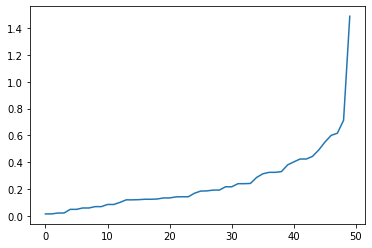

In [39]:
# DBSCAN
cluster_dataSet = toronto_venues[['Venue Latitude','Venue Longitude']]
cluster_dataSet = StandardScaler().fit_transform(cluster_dataSet)

# Calculate optimal eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cluster_dataSet)
distances, indices = nbrs.kneighbors(cluster_dataSet)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The epsilon value was rounded down to 0.6 and the min_samples value was set to 2

In [40]:
# Compute DBSCAN
db = DBSCAN(eps=0.6, min_samples=2).fit(cluster_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# adding cluster on data frame
toronto_venues["Cluster"] = labels

clusterNum = len(set(labels))

print( 'There are {} clusters'.format(clusterNum - 3) )
toronto_venues.head()

There are 2 clusters


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue category,Cluster
0,Central Bay Street,43.657952,-79.387383,Hailed Coffee,43.658868,-79.383807,Coffee Shop,0
1,Central Bay Street,43.657952,-79.387383,The Alley,43.665827,-79.385383,Coffee Shop,0
2,Central Bay Street,43.657952,-79.387383,HotBlack Coffee,43.650271,-79.388563,Coffee Shop,0
3,Central Bay Street,43.657952,-79.387383,Fahrenheit Coffee,43.652416,-79.372916,Coffee Shop,0
4,Central Bay Street,43.657952,-79.387383,Dineen Coffee Co,43.651132,-79.379023,Coffee Shop,0


In [41]:
toronto_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue category,Cluster
45,Central Bay Street,43.657952,-79.387383,Tim Hortons,43.628192,-79.489530,Coffee Shop,3
46,Central Bay Street,43.657952,-79.387383,Stock T.C,43.709348,-79.399293,Coffee Shop,2
47,Central Bay Street,43.657952,-79.387383,Jet Fuel Coffee Shop Inc,43.665336,-79.368143,Coffee Shop,0
48,Central Bay Street,43.657952,-79.387383,Starbucks,43.725227,-79.448889,Coffee Shop,-1
49,Central Bay Street,43.657952,-79.387383,Starbucks,43.639975,-79.381174,Coffee Shop,0


# Visualization of the clusters in the map

In [42]:
# Visualize parks
map_CentralBay= folium.Map(location = [43.677993, -79.390267], zoom_start = 12)

# Colormap
colors_array = cm.gist_ncar(np.linspace(0, 1, clusterNum))
color_map = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, label, cluster in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue'], toronto_venues['Cluster']):
    popup = label
    c = 'red'
    if cluster == 0:
        c = color_map[cluster]
        popup = label + '<br>' + 'Cluster ' + str(cluster + 1)
                       
    label = folium.Popup(popup)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color=c, fill=True, fill_color=c, fill_opacity=0.7,parse_html=False).add_to(map_CentralBay) 
    
map_CentralBay

# Conclusion

This project was a good practice to learn about the work and tasks to be performed in data science and visualization. 

To reach the goal like that of a company, such as knowing where to open a new location.
 Several Python libraries were used to both extract data from multiple online sources, apply cleaning on the dataset (sometimes checking one by one lines of results) and merge them with a main dataset. 

We also visualize the datasets, apply clustering to make the dataset suitable for implementing a machine learning algorithm (k-means) to group neighborhoods with similar coffee profiles. 

Foursquare API to get the data of the locals, it is really a good tool for this kind of project, but the problem using the free version only limited us to have a data frame of 50 values.

Regarding Folium to show the latitudes and longitudes of the neighborhoods requires time to obtain the expected results. 

 This project can be improved with more information with more data from surrounding cafes, probably would be having a premium subscription on foursquare. And also add more factors such as demographics.